## Spark Setup
We create a SparkSession to process batch CSvs and micro-batch inventory streams.
The app name and master configuration are from "config.yaml".

In [23]:
from pathlib import Path

project_root = Path.cwd().parent

In [24]:
import yaml
from pyspark.sql import SparkSession


# Load config.yaml
with open("../config.yaml", 'r') as f:
    cfg = yaml.safe_load(f)

 # Initialize Spark Session
spark = (SparkSession.builder
    .appName(cfg["spark"]["app_name"])
    .master(cfg["spark"]["master"])
    .config("spark.mongodb.write.connection.uri", "mongodb://localhost:27017/retail_db")
    .config("spark.jars.packages", "org.mongodb.spark:mongo-spark-connector_2.12:10.5.0")
    .getOrCreate())
spark

In [25]:
print(spark.sparkContext.getConf().get("spark.jars"))

file:///home/prabin/.ivy2/jars/org.mongodb.spark_mongo-spark-connector_2.12-10.5.0.jar,file:///home/prabin/.ivy2/jars/org.mongodb_mongodb-driver-sync-5.1.4.jar,file:///home/prabin/.ivy2/jars/org.mongodb_bson-5.1.4.jar,file:///home/prabin/.ivy2/jars/org.mongodb_mongodb-driver-core-5.1.4.jar,file:///home/prabin/.ivy2/jars/org.mongodb_bson-record-codec-5.1.4.jar


## Data Ingestion
We are loading batch load of historical sales and customers data and a stimulated mini-stream files drop for inventory sensor events.

In [26]:
# Configuring path for global use
sales_path = project_root/ "data" / "raw" /"sales_data.csv"
customers_path = project_root/ "data" / "raw" /"customers_data.csv"
inventory_path = project_root/ "data" / "raw" /"inventory_stream"

In [27]:
sales_df = spark.read.csv(str(sales_path), header=True, inferSchema=True)
customers_df = spark.read.csv(str(customers_path), header=True, inferSchema=True)

sales_df.show(5)
customers_df.show(5)


+------+--------+------+--------+-----------+--------+-------+
|txn_id|    date|sku_id|store_id|customer_id|quantity|  price|
+------+--------+------+--------+-----------+--------+-------+
|  T522|20250830|  P001|    X001|       C001|      18|1719.85|
|  T618|20250830|  P001|    X001|       C001|      11|1192.01|
|  T424|20250830|  P001|    X001|       C004|      26|2613.83|
|  T565|20250830|  P001|    X001|       C001|      50|5315.88|
|  T686|20250830|  P001|    X001|       C001|      45|4468.59|
+------+--------+------+--------+-----------+--------+-------+
only showing top 5 rows

+-----------+-------------+------------+-----------+
|customer_id|last_purchase|total_orders|total_spend|
+-----------+-------------+------------+-----------+
|       C001|     20250828|          36|       6516|
|       C002|     20250826|          27|       5292|
|       C003|     20250823|          26|       2574|
|       C004|     20250828|          37|       2331|
+-----------+-------------+----------

We have to define schema for Spark as Spark would not know the schema for inventory as we will be uploading inventory stream batch files incrementally.

In [28]:
from pyspark.sql.types import StructType, StructField, StringType, DoubleType

# Define Schema
inventory_schema = StructType([
    StructField("timestamp", StringType(), True),
    StructField("store_id", StringType(), True),
    StructField("sku_id", StringType(), True),
    StructField("on_stock", DoubleType(), True),
])

# Read streaming JSON with mini-batch drops
inventory_df = spark.readStream \
    .format("json") \
    .schema(inventory_schema) \
    .option("maxFilesPerTrigger",1) \
    .load(str(inventory_path))

inventory_df.printSchema()



root
 |-- timestamp: string (nullable = true)
 |-- store_id: string (nullable = true)
 |-- sku_id: string (nullable = true)
 |-- on_stock: double (nullable = true)



## Processing Layer - Curate the Data
### Daily item-store sales
It tells us how many items were in stock for each SKU at each store per day. This is the foundation for demand calculations.
### Moving Average Demand
It helps us smooth out fluctuations and detect trends. For streaming , we can compute it using window functions.
### Stock-Out Risk Signal
It shows risk signals for Stock-Out.
### RFM Analysis On Customers
It involves Recency which means how recently a customer purchased, Frequency means how often a customer purchased and Monetary means total spend.


# Base function to serve MongoDB

In [29]:
mongo_uri = cfg["mongodb"]["uri"]
mongo_db = cfg["mongodb"]["database"]
collections = cfg["mongodb"]["collections"]

# Threshold stock quantity min
stock_threshold = cfg["thresholds"]["stock_out_qty"]

In [30]:
def write_to_mongo(df, collection_key, mode="overwrite"):
    collection_name = collections[collection_key]
    df.write \
      .format("mongodb") \
      .mode(mode) \
      .option("spark.mongodb.output.uri", mongo_uri) \
      .option("database", mongo_db) \
      .option("collection", collection_name) \
      .save()



# Daily Item-Store Sales And Moving Average OF Quantity

In [31]:
from pyspark.sql import functions as f
from pyspark.sql.window import Window

# Aggregate sales at store, date and sku level
sales_df = sales_df.withColumn("date", f.to_date(f.col("date").cast("string"), "yyyyMMdd"))
daily_item_store = sales_df.groupby("date", "store_id", "sku_id") \
    .agg(
    f.sum("quantity").alias("total_qty"),
    f.round(f.sum("price"),2).alias("total_sales"),
    f.round(f.avg("price"), 2).alias("avg_price"),
    f.max("price").alias("max_price"),
    f.min("price").alias("min_price")
)

# Moving Average of Quantity/Demand
window_spec = Window.partitionBy("store_id", "sku_id").orderBy("date").rowsBetween(-6,0)
daily_item_store = daily_item_store.withColumn(
    "moving_avg_qty",
    f.round(f.avg("total_qty").over(window_spec), 2)  # round to 2 decimals
)


# Performance optimizations

# Partition distributes DataFrame across Spark partitions based on store_id and sku_id. This helps reduce shuffling when performing joins or window operation because rows with the same store and SKU end up in the same partition. It improves performance for subsequent operations like window functions or aggregations.
daily_item_store = daily_item_store.repartition("store_id", "sku_id")

# If the following DataFrame is used multiple times, Spark doesn't need to recompute it from scratch each time. This speeds up repeated operations and avoids redundant computations.
daily_item_store = daily_item_store.cache()

daily_item_store.show(5)

write_to_mongo(daily_item_store, "sales") # Pushes curated sales data to MongoDB

25/09/21 13:00:15 WARN CacheManager: Asked to cache already cached data.


+----------+--------+------+---------+-----------+---------+---------+---------+--------------+
|      date|store_id|sku_id|total_qty|total_sales|avg_price|max_price|min_price|moving_avg_qty|
+----------+--------+------+---------+-----------+---------+---------+---------+--------------+
|2025-08-30|    X002|  P002|      161|   32226.96|  4028.37|  8834.62|  1279.78|         161.0|
|2025-08-31|    X002|  P002|      226|   45238.43|   5654.8|  9948.41|  1303.38|         193.5|
|2025-09-01|    X002|  P002|       80|   15406.49|   3081.3|   5835.6|  1475.39|        155.67|
|2025-09-02|    X002|  P002|      214|    41073.2|   5867.6| 10071.92|  2118.02|        170.25|
|2025-09-03|    X002|  P002|      141|   28619.31|  5723.86|  9367.63|  1433.37|         164.4|
+----------+--------+------+---------+-----------+---------+---------+---------+--------------+
only showing top 5 rows



# Stock-Out Risk Signal

In [32]:
# Join inventory with daily_item_store to get moving_avg_qty for that SKU and store
inventory_with_sales = inventory_df.withColumn("date_only", f.to_date("timestamp")).join(
    daily_item_store.withColumnRenamed("date", "date_only")
    .select("store_id", "sku_id", "date_only", "moving_avg_qty"),
    on=["store_id", "sku_id", "date_only"],
    how="left"
)
inventory_with_sales = inventory_with_sales.withColumn(
    "stock_out_signal",
    f.when(f.col("moving_avg_qty").isNotNull() & (f.col("on_stock") <= f.col("moving_avg_qty")), 1)
     .otherwise(0)
)

 # Partition to improve joins and window ops
inventory_with_sales = inventory_with_sales.repartition("store_id", "sku_id")

# Streaming DataFrames cannot be cached.

# Risk signal will be stored in MongoDB. Write method cannot be used in streaming DataFrames. We will have to use writeStream for this DataFrame

# Spark requires checkpoints to keep track of what data has been already processed.

# Path for checkpoint and make sure it exists
checkpoint_path = Path(project_root / "checkpoints" / "inventory_stock")
checkpoint_path.mkdir(parents=True, exist_ok=True)

# Stores risk signal in MongoDB
# --- Write streaming data to MongoDB (append mode) ---
stream_query = inventory_with_sales.writeStream \
    .format("mongodb") \
    .option("spark.mongodb.output.uri", mongo_uri) \
    .option("database", mongo_db) \
    .option("collection", "stock") \
    .option("checkpointLocation", str(checkpoint_path / "mongo_checkpoint")) \
    .outputMode("append") \
    .start()

# --- Optional: monitor stream until all batches processed ---
stream_query.awaitTermination(10) # Wait 10 seconds
stream_query.stop()

25/09/21 13:00:16 WARN ResolveWriteToStream: spark.sql.adaptive.enabled is not supported in streaming DataFrames/Datasets and will be disabled.
25/09/21 13:00:16 WARN CaseInsensitiveStringMap: Converting duplicated key checkpointLocation into CaseInsensitiveStringMap.
25/09/21 13:00:16 WARN CaseInsensitiveStringMap: Converting duplicated key checkpointLocation into CaseInsensitiveStringMap.
25/09/21 13:00:16 WARN CaseInsensitiveStringMap: Converting duplicated key checkpointLocation into CaseInsensitiveStringMap.
25/09/21 13:00:16 WARN CaseInsensitiveStringMap: Converting duplicated key checkpointLocation into CaseInsensitiveStringMap.
25/09/21 13:00:16 WARN CaseInsensitiveStringMap: Converting duplicated key checkpointLocation into CaseInsensitiveStringMap.
25/09/21 13:00:16 WARN CaseInsensitiveStringMap: Converting duplicated key checkpointLocation into CaseInsensitiveStringMap.
25/09/21 13:00:17 WARN CaseInsensitiveStringMap: Converting duplicated key checkpointLocation into CaseIns

## Stream mini-stimulation query

In [33]:
console_query = inventory_with_sales.writeStream \
    .format("console") \
    .option("truncate", False) \
    .option("numRows", 20) \
    .option("checkpointLocation", str(checkpoint_path / "console_checkpoint")) \
    .start()

# Stop after 5 batches
batch_count = 0
while batch_count < 5:
    console_query.awaitTermination(1)  # wait 1 sec per loop
    batch_count = len(console_query.recentProgress)

console_query.stop()
print("Stopped stream after 5 batches")


25/09/21 13:00:26 WARN ResolveWriteToStream: spark.sql.adaptive.enabled is not supported in streaming DataFrames/Datasets and will be disabled.


-------------------------------------------
Batch: 0
-------------------------------------------
+--------+------+----------+-------------------+--------+--------------+----------------+
|store_id|sku_id|date_only |timestamp          |on_stock|moving_avg_qty|stock_out_signal|
+--------+------+----------+-------------------+--------+--------------+----------------+
|X002    |P002  |2025-08-31|2025-08-31T14:27:13|175.0   |193.5         |1               |
|X002    |P003  |2025-08-31|2025-08-31T22:54:10|205.0   |199.5         |0               |
|X001    |P001  |2025-08-31|2025-08-31T16:51:03|252.0   |258.0         |1               |
|X002    |P001  |2025-08-31|2025-08-31T20:13:28|113.0   |179.5         |1               |
|X001    |P003  |2025-08-31|2025-08-31T19:38:33|212.0   |112.0         |0               |
|X001    |P002  |2025-08-31|2025-08-31T07:07:16|146.0   |240.5         |1               |
+--------+------+----------+-------------------+--------+--------------+----------------+

--

## RFM features for customers

In [34]:
# Convert last_purchase to proper date
customers_df = customers_df.withColumn(
    "last_purchase_date",
    f.to_date("last_purchase", "yyyyMMdd")
)


#reference date, the day analysis is done
reference_date = "2025-09-20"

# Compute RFM
rfm = customers_df.withColumn(
    "recency", f.datediff(f.lit(reference_date), f.col("last_purchase_date"))
).withColumn(
    "frequency", f.col("total_orders").cast("int")
).withColumn(
    "monetary", f.col("total_spend").cast("double")
).select("customer_id", "last_purchase_date", "recency", "frequency", "monetary")

# Compute RFM scoring

#Computing quantiles for dynamic scoring
recency_q = rfm.approxQuantile("recency",[0.25,0.5,0.75],0)
frequency_q = rfm.approxQuantile("frequency",[0.25,0.5,0.75],0)
monetary_q = rfm.approxQuantile("monetary",[0.25,0.5,0.75],0)


# Recency: lower recency = higher score
rfm = rfm.withColumn(
    "recency_score",
    f.when(f.col("recency") <= recency_q[0], 4)
     .when(f.col("recency") <= recency_q[1], 3)
     .when(f.col("recency") <= recency_q[2], 2)
     .otherwise(1)
)

# Frequency: higher frequency = higher score
rfm = rfm.withColumn(
    "frequency_score",
    f.when(f.col("frequency") >= frequency_q[2], 4)
     .when(f.col("frequency") >= frequency_q[1], 3)
     .when(f.col("frequency") >= frequency_q[0], 2)
     .otherwise(1)
)

# Monetary: higher spend = higher score
rfm = rfm.withColumn(
    "monetary_score",
    f.when(f.col("monetary") >= monetary_q[2], 4)
     .when(f.col("monetary") >= monetary_q[1], 3)
     .when(f.col("monetary") >= monetary_q[0], 2)
     .otherwise(1)
)

rfm= rfm.withColumn(
    "RFM_total_score",
    f.col("recency_score") + f.col("frequency_score") + f.col("monetary_score")
)

rfm.select("customer_id", "last_purchase_date", "recency", "frequency", "monetary", "recency_score", "frequency_score", "monetary_score", "RFM_total_score").show(truncate=False)

# Repartition to improve parallelism
rfm = rfm.repartition("customer_id")

# Caching avoids recomputation
rfm = rfm.cache()

# Push curated data to mongoDB
write_to_mongo(rfm, "customers")


+-----------+------------------+-------+---------+--------+-------------+---------------+--------------+---------------+
|customer_id|last_purchase_date|recency|frequency|monetary|recency_score|frequency_score|monetary_score|RFM_total_score|
+-----------+------------------+-------+---------+--------+-------------+---------------+--------------+---------------+
|C001       |2025-08-28        |23     |36       |6516.0  |4            |4              |4             |12             |
|C002       |2025-08-26        |25     |27       |5292.0  |2            |3              |4             |9              |
|C003       |2025-08-23        |28     |26       |2574.0  |1            |2              |3             |6              |
|C004       |2025-08-28        |23     |37       |2331.0  |4            |4              |2             |10             |
+-----------+------------------+-------+---------+--------+-------------+---------------+--------------+---------------+



25/09/21 13:00:28 WARN CacheManager: Asked to cache already cached data.


# Stock_out Prediction Model

In [35]:
stock_df = spark.read.format("mongodb") \
    .option("spark.mongodb.read.connection.uri", "mongodb://localhost:27017") \
    .option("spark.mongodb.read.database", "retail_db") \
    .option("spark.mongodb.read.collection", "stock") \
    .load()


In [36]:
stock_df.printSchema()

root
 |-- _id: string (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- date_only: timestamp (nullable = true)
 |-- moving_avg_qty: double (nullable = true)
 |-- on_stock: double (nullable = true)
 |-- sku_id: string (nullable = true)
 |-- stock_out_signal: integer (nullable = true)
 |-- store_id: string (nullable = true)
 |-- timestamp: string (nullable = true)



In [37]:
stock_df.show(5)
df = stock_df.limit(1000) # As stock was a streaming DataFrame , I have to make it static to process and train model.

+--------------------+-------------------+---------+--------------+--------+------+----------------+--------+-------------------+
|                 _id|               date|date_only|moving_avg_qty|on_stock|sku_id|stock_out_signal|store_id|          timestamp|
+--------------------+-------------------+---------+--------------+--------+------+----------------+--------+-------------------+
|68ce7b3b5168644cc...|2025-08-31 00:00:00|     NULL|         200.0|    50.0|  P001|               1|    X001|2025-08-31T13:06:28|
|68ce7b3b5168644cc...|2025-08-31 00:00:00|     NULL|         236.5|    83.0|  P003|               1|    X002|2025-08-31T20:53:37|
|68ce7b3b5168644cc...|2025-08-31 00:00:00|     NULL|         198.5|    26.0|  P001|               1|    X002|2025-08-31T11:40:18|
|68ce7b3b5168644cc...|2025-08-31 00:00:00|     NULL|         216.0|    33.0|  P002|               1|    X002|2025-08-31T02:40:08|
|68ce7b3b5168644cc...|2025-08-31 00:00:00|     NULL|         179.0|    58.0|  P003|       

## Prepare Data

In [38]:
# Drop unnecessary columns
df = df.drop("_id", "date", "date_only")

#Extract timestamp features

df = df.withColumn("ts", f.to_timestamp("timestamp")) \
    .withColumn("day_of_week", f.dayofweek("ts")) \
    .withColumn("month", f.month("ts")) \
    .withColumn("day", f.dayofmonth("ts")) \
    .withColumn("hour", f.hour("ts")) \
    .withColumn("is_weekend", f.when(f.dayofweek("ts").isin([1,7]),1).otherwise(0))



In [39]:

df.select([f.count(f.when(f.col(c).isNull(), c)).alias(c) for c in df.columns]).show() # Verify if data has Null values

+--------------+--------+------+----------------+--------+---------+---+-----------+-----+---+----+----------+
|moving_avg_qty|on_stock|sku_id|stock_out_signal|store_id|timestamp| ts|day_of_week|month|day|hour|is_weekend|
+--------------+--------+------+----------------+--------+---------+---+-----------+-----+---+----+----------+
|             0|       0|     0|               0|       0|        0|  0|          0|    0|  0|   0|         0|
+--------------+--------+------+----------------+--------+---------+---+-----------+-----+---+----+----------+



## Encode categorical values

In [40]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder


sku_indexer = StringIndexer(inputCol="sku_id", outputCol="sku_index")
store_indexer = StringIndexer(inputCol="store_id", outputCol="store_index")

sku_encoder = OneHotEncoder(inputCol="sku_index", outputCol="sku_vec")
store_encoder = OneHotEncoder(inputCol="store_index", outputCol="store_vec")

## Assemble features

In [41]:
from pyspark.ml.feature import VectorAssembler

feature_cols = ["on_stock", "moving_avg_qty", "day_of_week", "month", "hour", "is_weekend", "sku_vec", "store_vec"]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")


## Choosing logistic regression for binary prediction

In [42]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(featuresCol="features", labelCol="stock_out_signal")


## Building the pipeline
It lets us define sequence of steps where the output of one step becomes input for next

In [43]:
from pyspark.ml import Pipeline

pipeline = Pipeline(stages=[sku_indexer, store_indexer, sku_encoder, store_encoder, assembler, lr])


## Train/Test split and training

In [45]:
train, test = df.randomSplit([0.8, 0.2], seed=52)
model = pipeline.fit(train)
predictions = model.transform(test)


## Evaluate


In [46]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator(labelCol="stock_out_signal", metricName="areaUnderROC")
auc = evaluator.evaluate(predictions)
print("Test AUC:", auc)


Test AUC: 1.0


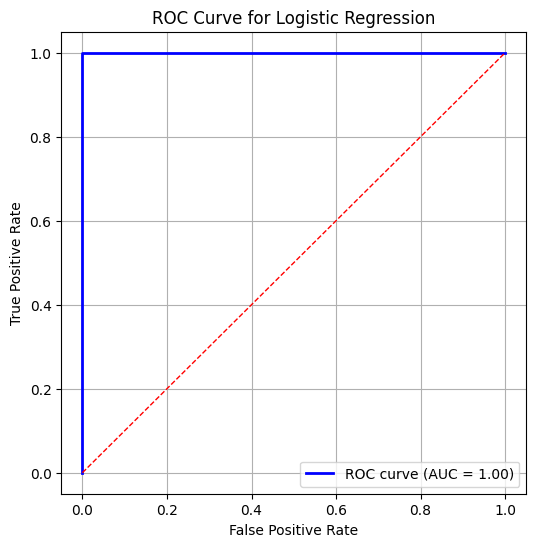

In [54]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Convert to pandas
pdf = predictions.select("stock_out_signal", "probability").toPandas()
y_true = pdf["stock_out_signal"]
y_scores = pdf["probability"].apply(lambda x: x[1])  # probability of stock-out

fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0,1], [0,1], color='red', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Logistic Regression')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


Maybe the model is generalizing too well due to small dataset. This is better model however suspicious and may not work if threshold is changed or tested on unseen data.

## Saving the model

In [57]:
model_path = project_root / "data" / "models" / "stock_out_model"

model.write().overwrite().save(str(model_path))
print("Model saved at:", model_path)


Model saved at: /home/prabin/projects/BDA311/Nova_retail_assign/data/models/stock_out_model


# Saving test data for model evaluation

In [61]:
cols_to_save = [
    "on_stock",
    "moving_avg_qty",
    "day_of_week",
    "month",
    "day",
    "hour",
    "is_weekend",
    "sku_id",
    "store_id",
    "stock_out_signal"
]


In [62]:
# Ensure folder exist
curated_path = project_root / "data" / "curated"
curated_path.mkdir(parents=True, exist_ok=True)

# Select relevant columns
test_df = df.select(cols_to_save)

# Save as Parquet (recommended for Spark)
test_path = curated_path / "test_inventory.parquet"
test_df.write.mode("overwrite").parquet(str(test_path))

print("Test data saved at:", test_path)


Test data saved at: /home/prabin/projects/BDA311/Nova_retail_assign/data/curated/test_inventory.parquet
